<a href="https://colab.research.google.com/github/ProfessorDong/Deep-Learning-Course-Examples/blob/master/DRL_Examples/Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning: Solving Blackjack with the Gymnasium Environment

Q-Learning is a model-free reinforcement learning algorithm that learns the optimal policy by iteratively updating the Q-value for each state-action pair. In this context, the agent selects the action with the highest Q-value for a given state. Q-Learning is particularly well-suited for problems with finite states and actions, such as the game of Blackjack. By leveraging the Gymnasium environment, we can efficiently implement and test the Q-Learning algorithm to solve the Blackjack problem.

In [1]:
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install tqdm
!pip install gymnasium
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# !pip install collection
from collections import defaultdict

import matplotlib.pyplot as plt  #drawing plots
from matplotlib.patches import Rectangle, Circle, Polygon #draw shaped
import numpy as np  #data and array manipulation
import seaborn as sns

from tqdm import tqdm  #progress bar

In [3]:
import gymnasium as gym
env = gym.make('Blackjack-v1', sab=True, render_mode="rgb_array")

In [4]:
# Reset the environment
done = False
observation, info = env.reset()

In [5]:
from os import truncate
# Sample a random action from all valid actions
action = env.action_space.sample()

# Execute the action in the environment and receive info after taking the step
observation, reward, terminated, truncated, info = env.step(action)

# observation = (16,9,False)  # (The players current sum, Values of the dealer's face-up card, Boolean whether the player holds a usable ace, i.e., it counts as 11 without busting)
# If terminated=True we should stop the current episode and begin a new one using env.reset()

In [6]:
# Epsilon-greedy strategy to solve Blackjack

# from collections import defaultdict
# import numpy as np

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        # Initialize a RL agent with empty dictionary of state-action value (q_values), a learning rate and an epsilon
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # Return the best action with probability (1-epsilon) otherwise a random action with probability epsilon to ensure exploration
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs:tuple[int,int,bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int,int,bool]
    ):  # Add colon here
        # Update the Q-value of an action
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [7]:
# Hyperparameters
learning_rate = 0.01
n_episodes = 1000 #100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

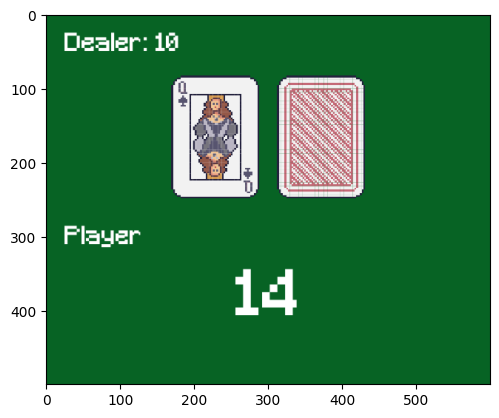

100%|██████████| 1000/1000 [06:52<00:00,  2.43it/s]


In [8]:
from ipywidgets.widgets.widget_output import clear_output
# Training

from IPython.display import clear_output

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
  obs, info = env.reset()
  done = False
  clear_output()

  # Play one episode
  while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # Update the agent
    agent.update(obs, action, reward, terminated, next_obs)
    frame = env.render()
    plt.imshow(frame)
    plt.show()

    # Update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs

  agent.decay_epsilon()

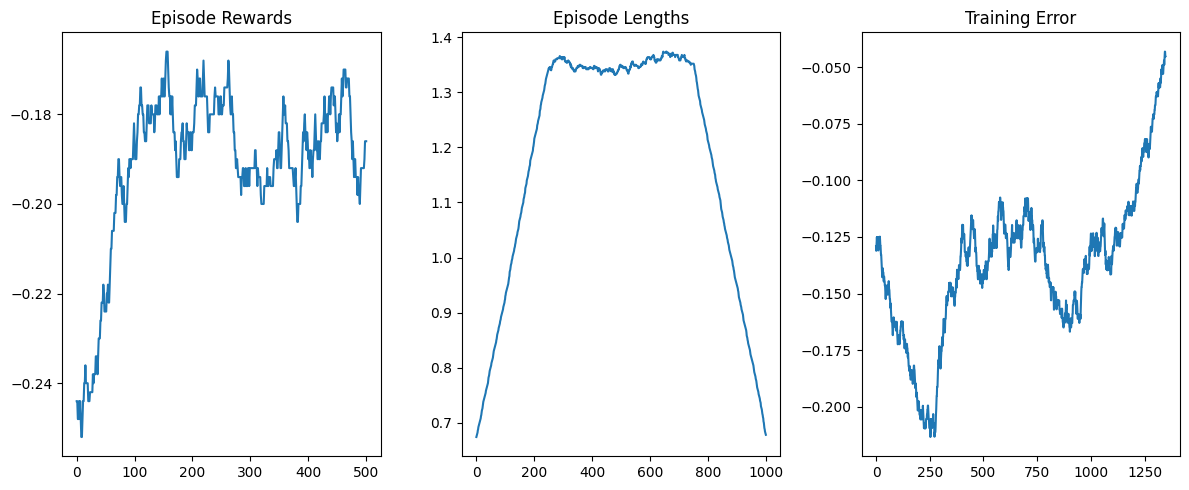

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )/rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )/rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(
        np.array(agent.training_error).flatten(), np.ones(rolling_length), mode="same"
    )/rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()